In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
from skimage import io
from skimage import color
import cv2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


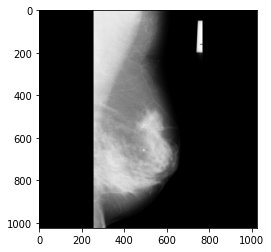

In [11]:
img = cv2.imread('/content/drive/MyDrive/MINI_MIAS/malignant_cases/mdb170.png')
#plt.imshow(img)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')


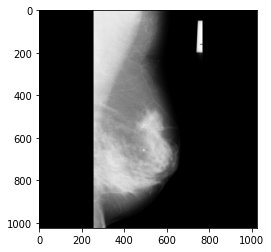

In [12]:
def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)
    return image

right_gray = right_orient_mammogram(gray)
plt.imshow(right_gray,cmap='gray')

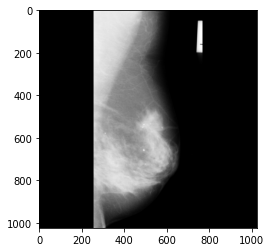

In [13]:
median_img = cv2.medianBlur(right_gray,3)
plt.imshow(median_img,cmap='gray')

In [ ]:
def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image

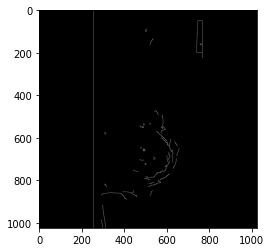

In [17]:
'''from skimage.feature import canny
from skimage.filters import sobel
def canny(image):
    canny_image = cv2.Canny(image,5) #upper and lower thresholds (not an edge, edge)
    return sobel(canny_image)

canny_img = canny(median_img)
plt.imshow(canny_img,cmap='gray')  '''

from skimage.feature import canny
from skimage.filters import sobel
def apply_canny(image):
    canny_image = canny(image, 5)
    #return sobel(canny_img)
    return canny_image

canny_img = canny(median_img)
plt.imshow(canny_img,cmap='gray')    

In [18]:
from skimage.transform import hough_line, hough_line_peaks
def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    return lines

hough_lines = get_hough_lines(canny_img)    


print(hough_lines)


#for i in range(len(hough_lines)):
     #hough_lines[i] = abs(hough_lines[i])




All hough lines
Angle: 2.51, Dist: 747.76
Angle: 0.50, Dist: 262.59
Angle: -0.50, Dist: 251.59
Angle: 0.50, Dist: 769.77
Angle: -8.55, Dist: 158.55
[{'dist': 747.758025543666, 'angle': 2.513966480446923, 'point1': [0, 17047.613532780895], 'point2': [1024, -6275.379423785037]}, {'dist': 262.59061097687277, 'angle': 0.5027932960893821, 'point1': [0, 29923.881182145466], 'point2': [1024, -86762.98126235345]}, {'dist': 251.5868139454608, 'angle': -0.5027932960893948, 'point1': [0, -28669.92806594053], 'point2': [1024, 88016.93437855544]}, {'dist': 769.7656196064895, 'angle': 0.5027932960893821, 'point1': [0, 87719.72026537496], 'point2': [1024, -28967.142179123974]}, {'dist': 158.55471177079744, 'angle': -8.547486033519558, 'point1': [0, -1066.7814788365874], 'point2': [1024, 5746.331380527486]}]


In [19]:
def shortlist_lines(lines):
    MIN_ANGLE = -10
    MAX_ANGLE = 70
    MIN_DIST  = 4
    MAX_DIST  = 256
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
    return shortlisted_lines

shortlisted_lines = shortlist_lines(hough_lines)
print(shortlisted_lines)    


Shorlisted lines
Angle: -0.50, Dist: 251.59
Angle: -8.55, Dist: 158.55
[{'dist': 251.5868139454608, 'angle': -0.5027932960893948, 'point1': [0, -28669.92806594053], 'point2': [1024, 88016.93437855544]}, {'dist': 158.55471177079744, 'angle': -8.547486033519558, 'point1': [0, -1066.7814788365874], 'point2': [1024, 5746.331380527486]}]


In [34]:
from skimage.draw import polygon
def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

remove_pectoral(shortlisted_lines)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160]


In [ ]:
def display_image(filename):
    image = read_image(filename)
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)
    rr, cc = remove_pectoral(shortlisted_lines)
    image[rr, cc] = 0
    cv2.imwrite('image13.png', image)